In [16]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
import pathlib
from keras.layers import GlobalAveragePooling2D

In [17]:
data_dir = 'mango_6/' #Add full path to dataset
filepaths = []
labels = []

dir_names = os.listdir(data_dir)
print(dir_names)

for dir in dir_names:
    dir_path = os.path.join(data_dir, dir)
    filelist = os.listdir(dir_path)
    for file in filelist:
        fpath = os.path.join(dir_path, file)
        filepaths.append(fpath)
        labels.append(dir)

# Concatenate data paths with labels into one dataframe
file_name_series = pd.Series(filepaths, name= 'filepaths')
labels_series = pd.Series(labels, name='labels')
df = pd.concat([file_name_series, labels_series], axis= 1)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [18]:
# df.to_csv('mango.csv')
# df = pd.read_csv('mango.csv')
df.shape

(4000, 2)

In [19]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)
train_df.shape, valid_df.shape,test_df.shape

((3200, 2), (400, 2), (400, 2))

In [20]:
# Set the image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 16

# Define the data generators for the train and test sets
tr_gen = ImageDataGenerator(
    rescale=1./255,         # Scale the pixel values from 0-255 to 0-1
    rotation_range=40,      # Randomly rotate the images up to 40 degrees
    width_shift_range=0.2,  # Randomly shift the images horizontally up to 20% of the width
    height_shift_range=0.2, # Randomly shift the images vertically up to 20% of the height
    shear_range=0.2,       # Randomly apply shear transformations
    zoom_range=0.2,         # Randomly zoom in on the images
    horizontal_flip=True,   # Randomly flip the images horizontally
    fill_mode='nearest')    # Fill any empty pixels with the nearest available pixel


ts_gen = ImageDataGenerator(rescale=1./255)

In [21]:
train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= (img_width, img_height),
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= (img_width, img_height),
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= True,
                                      batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= (img_width, img_height),
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= True,
                                      batch_size= batch_size)


Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


In [22]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_height, img_width, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    # Implement your learning rate schedule here
    return lr

callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    # Add any other callbacks you may need (e.g., early stopping, model checkpointing)
]

In [24]:
%%time
history = model.fit(
    train_gen,
    epochs=2,
    validation_data=test_gen,
    #callbacks=[early_stop],
    verbose=1)

Epoch 1/2
200/200 [==============================] - 619s 3s/step - loss: 0.4487 - accuracy: 0.8487 - val_loss: 0.2816 - val_accuracy: 0.8950
Epoch 2/2
200/200 [==============================] - 533s 3s/step - loss: 0.1695 - accuracy: 0.9406 - val_loss: 0.2278 - val_accuracy: 0.9200
CPU times: total: 25min 47s
Wall time: 19min 24s


In [25]:
loss, accuracy = model.evaluate(train_gen)
print('Train accuracy:', accuracy)
loss, accuracy = model.evaluate(valid_gen)
print("Valid accuracy:", accuracy)
loss, accuracy = model.evaluate(test_gen)
print('Test accuracy:', accuracy)

200/200 [==============================] - 284s 1s/step - loss: 0.2183 - accuracy: 0.9319
Train accuracy: 0.9318749904632568
25/25 [==============================] - 31s 1s/step - loss: 0.2516 - accuracy: 0.9150
Valid accuracy: 0.9150000214576721
25/25 [==============================] - 30s 1s/step - loss: 0.2278 - accuracy: 0.9200
Test accuracy: 0.9200000166893005


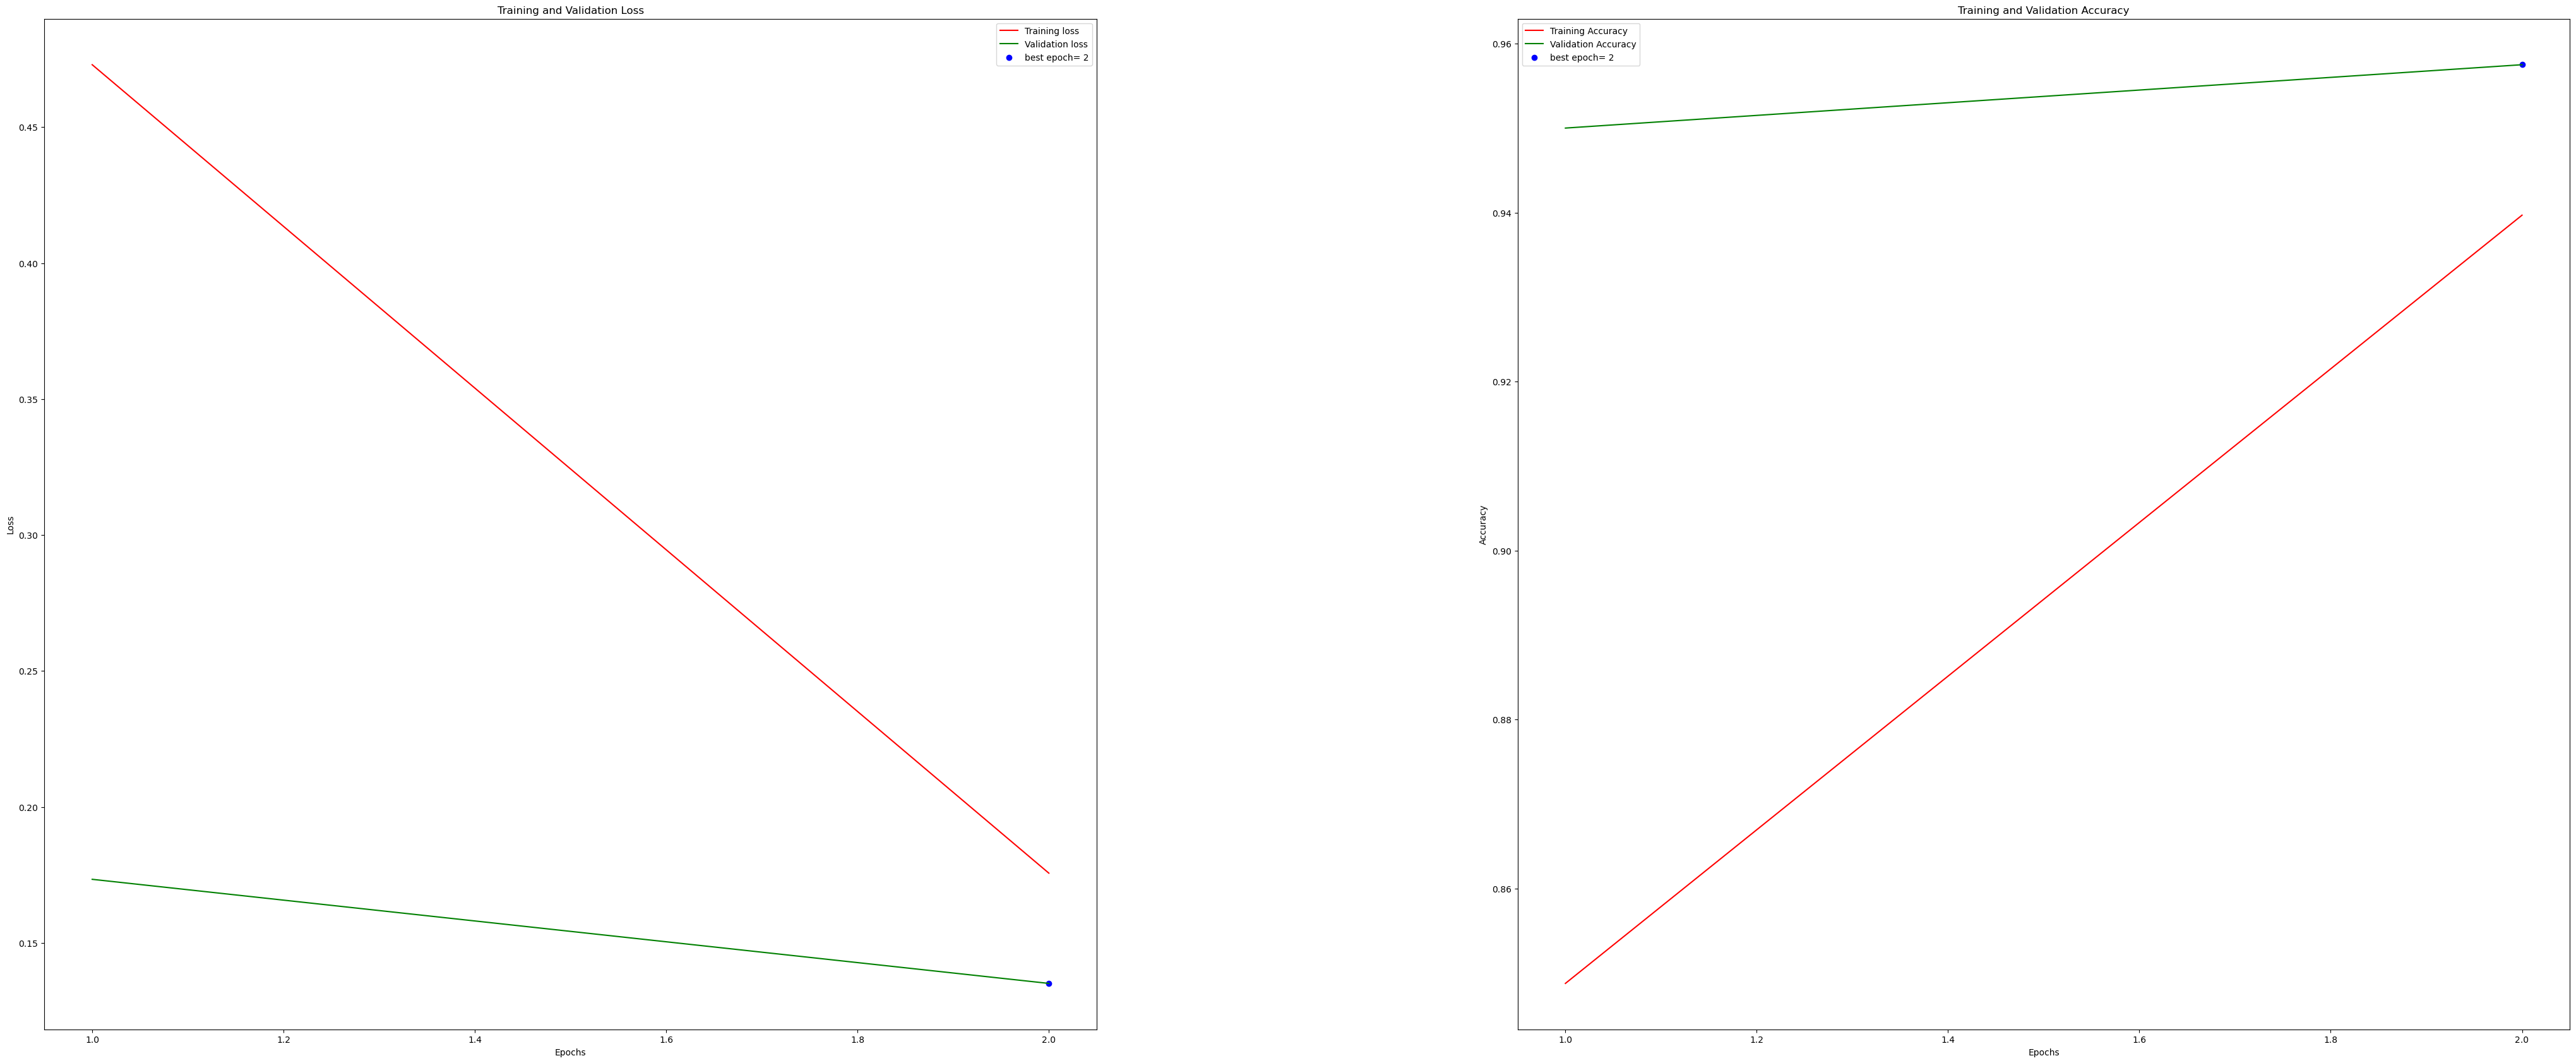

CPU times: total: 844 ms
Wall time: 1.24 s


In [11]:
%%time
import matplotlib.pyplot as plt

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (50, 20))
#plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest,  c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.subplot_tool()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
#plt.tight_layout(pad=20.0)
plt.show()

In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load a real image for testing


image_path = r"C:\Users\Mahek Patel\OneDrive\Pictures\Bacterial Canker.jpg"
#image_path = r"C:\Users\Mahek Patel\OneDrive\Pictures\ig1w.png"

  
img = image.load_img(image_path, target_size=(224, 224))  # Adjust the target size to match your model's input size
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.0  # Normalize the pixel values

# Make a prediction
predictions = model.predict(img)

class_labels = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']  # Replace with your actual class labels

predicted_class = class_labels[np.argmax(predictions)]
confidence = np.max(predictions)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence * 100:.2f}%")

1/1 [==============================] - 0s 188ms/step
Predicted Class: Bacterial Canker
Confidence: 96.70%


In [26]:
tf.keras.models.save_model(model,'final_model.h5')

C:\Users\Mahek Patel\AppData\Local\Temp\ipykernel_20300\3515889207.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'final_model.h5')
